# Zee: Zero Effort Crowdsourcing for Indoor Localization

This notebook implements the algorithm described in the Zee paper.

In [2]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import json

In [61]:
from datetime import datetime

In [ ]:
PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(PROJECT_HOME, "code", "indoor-location-competition-20")
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [4]:
# type: ignore
from compute_f import split_ts_seq, compute_step_positions
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

In [5]:
floor_data_dir = os.path.join(INDOOR_COMPETITION_20_DIR, "data", "site1", "F2")
path_data_dir = os.path.join(floor_data_dir, "path_data_files")
floor_plan_filename = os.path.join(floor_data_dir, "floor_image.png")
floor_info_filename = os.path.join(floor_data_dir, "floor_info.json")

## Data Extraction

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

In [7]:
path_filename = path_filenames[0]
path_datas = read_data_file(path_filename)

In [8]:
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint

In [19]:
gt_times = path_datas.waypoint[:, 0]
gt_location = path_datas.waypoint[:, 1:]

## Counting Steps

In [79]:
ts = path_datas.acce[:, 0].astype(np.int64)
ax = path_datas.acce[:, 1]
ay = path_datas.acce[:, 2]
az = path_datas.acce[:, 3]
acce = path_datas.acce[:, 1:]

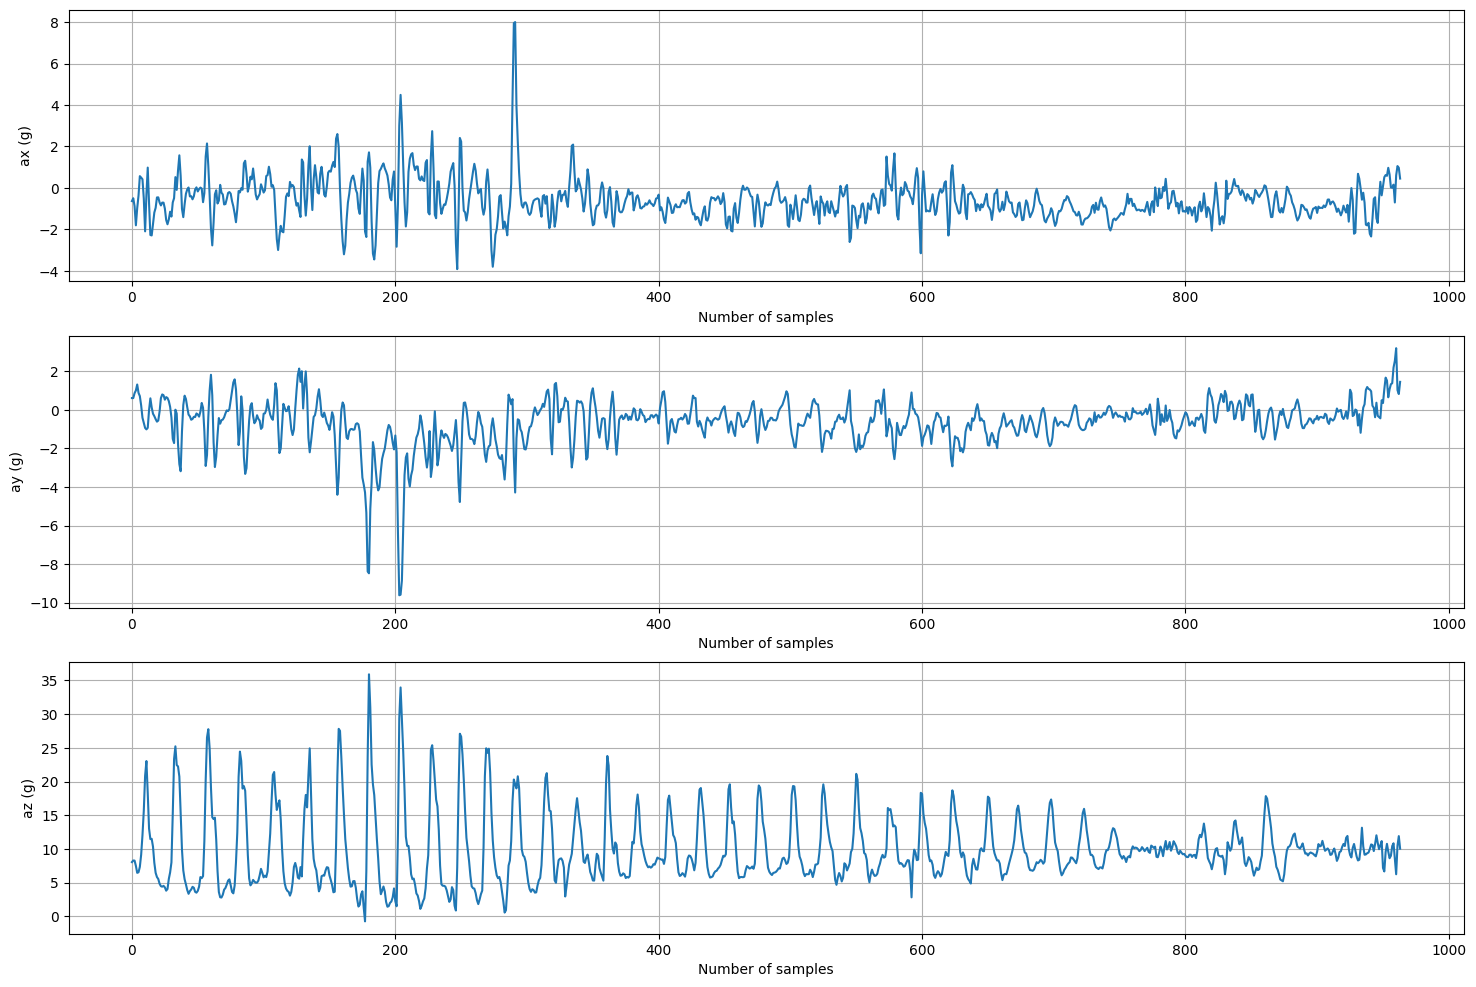

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(18, 12),)

ax1.plot(ax)
ax1.set_ylabel("ax (g)")
ax1.set_xlabel("Number of samples")

ax2.plot(ay)
ax2.set_ylabel("ay (g)")
ax2.set_xlabel("Number of samples")

ax3.plot(az)
ax3.set_ylabel("az (g)")
ax3.set_xlabel("Number of samples")

ax1.grid()
ax2.grid()
ax3.grid()

### Normalized Auto-correlation based Step Counting (NASC)

* The intuition behind NASC is that if the user is walking, then the auto-correlation will spike at the correct periodicity of the walker.

In [80]:
acce.shape

(964, 3)

In [87]:
np.sum(acce - np.mean(acce, axis=0), axis=0) /

array([1., 1., 1.])

In [88]:
def norm_acf(a, m, t):
  mu_m, sigma_m = np.mean(a[m:m+t], axis=0), np.std(a[m:m+t], axis=0)
  mu_mt, sigma_mt = np.mean(a[m+t:m+t*2], axis=0), np.std(a[m+t:m+t*2], axis=0)

  n_acf = np.sum((a[m:m+t] - mu_m) * (a[m+t:m+t*2] - mu_mt), axis=0) / t / sigma_m / sigma_mt

  return np.mean(n_acf)

In [89]:
accelerometer_sampling_freq = ts.shape[0] / (ts[-1] / 1000 - ts[0] / 1000)
print(
    "The sampling frequency of accelerometer is {:.2f}Hz".format(accelerometer_sampling_freq)
)

The sampling frequency of accelerometer is 49.71Hz


In [107]:
def max_norm_acf(a, m, t_min=40, t_max=100):
  """
  Finding the maximum normalized auto-correlation.
  """
  t_best = t_min
  n_acf_best = norm_acf(a, m, t_best)
  for t in range(t_min, t_max + 1):
    n_acf = norm_acf(a, m, t)
    if n_acf > n_acf_best:
      t_best = t
      n_acf_best = n_acf
  return n_acf_best, t_best


In [121]:
get_n_steps(1, 50)

0.04

In [119]:
get_state(acce, m=0)

(None, 50)

In [21]:
gt_location

array([[217.51762 ,  88.38969 ],
       [219.94548 ,  96.05509 ],
       [221.90855 , 104.69821 ],
       [223.3936  , 104.510475]])

In [22]:
step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)

In [25]:
with open(floor_info_filename) as f:
  floor_info = json.load(f)

In [27]:
visualize_trajectory(gt_location, 
                     floor_plan_filename, 
                     floor_info["map_info"]["width"], 
                     floor_info["map_info"]["height"], 
                     title='Ground Truth', show=False)